<strong><div dir=rtl >
<font size=4 >4) مدل بندی  <font><strong>

In [ ]:
pip install keras-tcn tensorflow==2.9, jdatetime

<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
در این تحقیق، هدف پیش‌بینی قیمت سهام فولاد با استفاده از داده‌های تحلیل احساسات اخبار و داده‌های تاریخی سهام است. برای انجام این کار از مدل یادگیری عمیق شبکه عصبی کانولوشنی زمانی (TCN) استفاده شده است. این مدل از ویژگی‌های تحلیل احساسات اخبار به همراه تاریخچه قیمت‌های سهام برای پیش‌بینی قیمت سهام در روزهای آتی استفاده می‌کند.
مدل TCN به دلیل قدرتش در پردازش داده‌های زمانی و یادگیری وابستگی‌های بلندمدت به ویژه در داده‌های مالی و خبری انتخاب شده است. مدل در دو فاز جداگانه آموزش داده شده است: یکی با استفاده از داده‌های تحلیل احساسات و دیگری بدون آن.


<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
مدل TCN (Temporal Convolutional Network) یک شبکه عصبی کانولوشنی است که به طور خاص برای پردازش داده‌های زمانی طراحی شده است. برخلاف مدل‌های بازگشتی مانند LSTM و GRU، مدل TCN از عملیات کانولوشنی برای استخراج ویژگی‌ها از داده‌های زمانی استفاده می‌کند که مزایای خاص خود را دارد:

    -  (Dilations): این ویژگی به مدل این امکان را می‌دهد که به فاصله‌های زمانی دورتر نگاه کند و اطلاعات از نقاط مختلف زمانی را در نظر بگیرد.

    - (Causal Padding): از این روش برای اطمینان از اینکه مدل فقط از اطلاعات گذشته برای پیش‌بینی استفاده می‌کند، استفاده می‌شود.



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load historical stock data
data = pd.read_csv('/content/drive/MyDrive/final_data.csv')
data.head()

,Date,Negative,Positive,Neutral,adjClose,number_of_news
0,1400-08-23,0.432091,0.254842,0.313067,2266.0,67
1,1400-08-24,0.328261,0.348066,0.323674,2178.0,61
2,1400-08-25,0.376083,0.299892,0.324026,2166.0,60
3,1400-08-26,0.386278,0.325757,0.287965,2154.0,122
4,1400-08-29,0.378658,0.335817,0.285525,2064.0,60


In [5]:
sen_df=pd.read_csv('/content/drive/MyDrive/sentiment_results_with_probs.csv')
des_df=pd.concat([sen_df.groupby(['category']).mean(['Negative','Positive','Neutral']),
 sen_df.groupby('category').count()['Title']],axis=1)
des_df.rename(columns={'Title': 'Count'}, inplace=True)
des_df.loc['Total']=list(des_df[des_df.columns[:-1]].mean())+[des_df['Count'].sum()]
des_df

,Negative,Positive,Neutral,Count
category,,,,
curruncy,0.474499,0.287466,0.238036,7349.0
economy,0.267840,0.383326,0.348835,7835.0
energy,0.460712,0.306679,0.232608,4582.0
industry,0.249340,0.478424,0.272237,5865.0
politics,0.391240,0.221773,0.386986,26174.0
Total,0.368726,0.335534,0.295740,51805.0


<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
تابع create_sequences توالی‌های زمانی از داده‌ها می‌سازد. این توالی‌ها شامل داده‌های ویژگی‌ها (شامل احساسات اخبار و تعداد اخبار) و هدف (قیمت سهام) در طول زمان هستند.
sequence_length نشان می‌دهد که تعداد روزهای گذشته برای پیش‌بینی قیمت در روز جاری استفاده می‌شود.
سپس، داده‌ها به دو مجموعه آموزشی و آزمایشی تقسیم می‌شوند.
90% داده‌ها برای آموزش و 10% باقی‌مانده برای ارزیابی مدل استفاده می‌شود

In [23]:
def create_sequences(df, feature_columns, target_column, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(df)):
        # Extract features and historical target
        features_sequence = df[feature_columns].iloc[i-sequence_length:i].values
        target_sequence = df[target_column].iloc[i-sequence_length:i].values.reshape(-1, 1)

        # Combine features and historical target into one sequence
        sequence = np.hstack((features_sequence, target_sequence))
        X.append(sequence)

        # Target value at the current time step
        y.append(df[target_column].iloc[i])

    return np.array(X), np.array(y)

# Define columns and parameters
feature_columns = ['Negative','Positive','Neutral','number_of_news']
target_column = 'adjClose'
sequence_length = 5

# Generate sequences
X, y = create_sequences(data, feature_columns, target_column, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)

print("Input shape:", X.shape)  
print("Target shape:", y.shape) 


Input shape: (679, 5, 5)
Target shape: (679,)


In [7]:
import numpy as np
import tensorflow as tf
import random

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
import os

# Enable deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'


<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
مدل TCN (Temporal Convolutional Network) مدل TCN با دو لایه Convolutional Temporal (TCN) ساخته می‌شود. این مدل قادر است به پیش‌بینی قیمت سهام بر اساس ویژگی‌های زمانی و تحلیل احساسات اخبار بپردازد.
لایه‌های TCN برای استخراج ویژگی‌های زمانی از داده‌ها و لایه Dense برای پیش‌بینی قیمت سهام در نظر گرفته شده‌اند.
از GlorotUniform برای مقداردهی اولیه وزن‌ها استفاده می‌شود تا نتایج بهتری حاصل شود.



In [8]:
from tensorflow.keras.models import Sequential
from tcn import TCN
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform

model = Sequential(name="TCN_Model_with_sentiments")
model.add(TCN(input_shape=(sequence_length, X_train.shape[2]),
              nb_filters=128,
              kernel_size=4,
              dilations=[1, 2, 4, 8, 16],
              padding='causal',
              return_sequences=True,
              kernel_initializer=GlorotUniform(seed=seed)))
model.add(TCN(nb_filters=64,
              kernel_size=3,
              dilations=[1, 2, 4, 8],
              padding='causal',
              return_sequences=False,
              kernel_initializer=GlorotUniform(seed=seed)))

model.add(Dense(1,kernel_initializer=GlorotUniform(seed=seed)))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model.summary()

Model: "TCN_Model_with_sentiments"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 5, 128)            594432    
                                                                 
 tcn_1 (TCN)                 (None, 64)                119360    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 713,857
Trainable params: 713,857
Non-trainable params: 0
_________________________________________________________________


<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
مدل آموزش داده می‌شود تا بتواند بهترین پیش‌بینی‌ها را از روی ویژگی‌ها (شامل احساسات و تعداد اخبار) برای پیش‌بینی قیمت سهام ارائه دهد.
پس از آموزش، خطا (Loss) و میانگین خطای مطلق (MAE) مدل روی داده‌های آزمایشی ارزیابی می‌شود


In [9]:
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.1)


Epoch 1/40
69/69 [==============================] - 7s 55ms/step - loss: 253929.1562 - mae: 283.9676 - val_loss: 105730.2266 - val_mae: 295.4023
Epoch 2/40
69/69 [==============================] - 3s 41ms/step - loss: 25431.1973 - mae: 116.8200 - val_loss: 36923.0195 - val_mae: 137.4548
Epoch 3/40
69/69 [==============================] - 2s 26ms/step - loss: 21302.1016 - mae: 107.0217 - val_loss: 37432.4258 - val_mae: 165.3159
Epoch 4/40
69/69 [==============================] - 2s 25ms/step - loss: 21294.7500 - mae: 109.5277 - val_loss: 44028.1758 - val_mae: 152.6643
Epoch 5/40
69/69 [==============================] - 2s 25ms/step - loss: 18275.2344 - mae: 99.0847 - val_loss: 24103.8145 - val_mae: 116.4217
Epoch 6/40
69/69 [==============================] - 2s 25ms/step - loss: 16480.5117 - mae: 94.0843 - val_loss: 20833.3457 - val_mae: 108.1410
Epoch 7/40
69/69 [==============================] - 2s 28ms/step - loss: 14350.3145 - mae: 89.8873 - val_loss: 29029.5410 - val_mae: 146.6954


In [24]:
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)


3/3 [==============================] - 0s 13ms/step - loss: 6169.8447 - mae: 62.9492
Test Loss: 6169.8447265625
Test MAE: 62.949249267578125


3/3 [==============================] - 0s 12ms/step


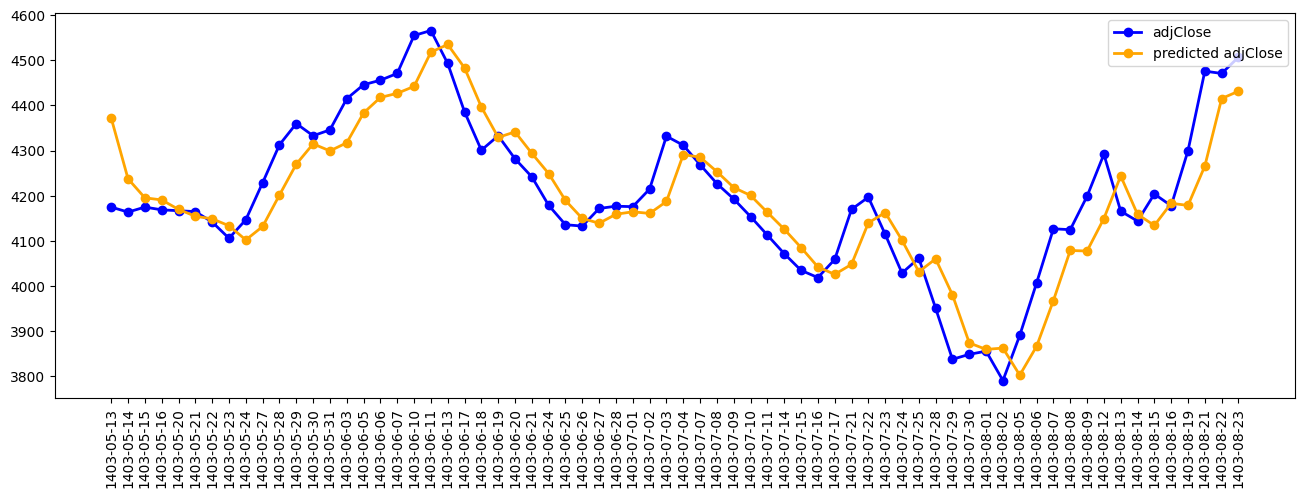

In [28]:
import matplotlib.pyplot as plt
y_pred=(model.predict(X_test)).reshape(-1)
plt.figure(figsize=(16, 5))
plt.plot(list(data['Date'][-len(y_test):]), y_test, color='blue', marker='o', linewidth=2, label='adjClose')
plt.plot(list(data['Date'][-len(y_pred):]), y_pred, color='orange', marker='o', linewidth=2, label='predicted adjClose')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
این بخش مدل TCN بدون استفاده از ویژگی‌های تحلیل احساسات اخبار را می‌سازد.
هدف این است که مقایسه‌ای بین مدل‌های با تحلیل احساسات و بدون تحلیل احساسات انجام دهیم.


In [30]:
# Define columns and parameters
feature_columns = []
target_column = 'adjClose'
sequence_length = 5

# Generate sequences
X, y = create_sequences(data, feature_columns, target_column, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)

print("Input shape:", X.shape)  
print("Target shape:", y.shape)  

Input shape: (679, 5, 1)
Target shape: (679,)


In [12]:
model2 = Sequential(name="TCN_Model")
model2.add(TCN(input_shape=(sequence_length, X_train.shape[2]),
              nb_filters=128,
              kernel_size=3,
              dilations=[1, 2, 4, 8, 16],
              padding='causal',
              return_sequences=True))
model2.add(TCN(nb_filters=64,
              kernel_size=3,
              dilations=[1, 2, 4, 8],
              padding='causal',
              return_sequences=False))
model2.add(Dense(1))

# Compile the model
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model2.summary()


Input shape: (679, 5, 1)
Target shape: (679,)
Model: "TCN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 5, 128)            444288    
                                                                 
 tcn_3 (TCN)                 (None, 64)                119360    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 563,713
Trainable params: 563,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
history2 = model2.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.1)


Epoch 1/40
69/69 [==============================] - 7s 50ms/step - loss: 51872584.0000 - mae: 2555.3347 - val_loss: 12180.7461 - val_mae: 83.6449
Epoch 2/40
69/69 [==============================] - 3s 37ms/step - loss: 11362.0625 - mae: 78.9574 - val_loss: 16835.6230 - val_mae: 98.0488
Epoch 3/40
69/69 [==============================] - 1s 21ms/step - loss: 9549.7520 - mae: 71.3988 - val_loss: 90678.4062 - val_mae: 286.3654
Epoch 4/40
69/69 [==============================] - 2s 24ms/step - loss: 12814.3584 - mae: 85.1903 - val_loss: 9892.1865 - val_mae: 70.7200
Epoch 5/40
69/69 [==============================] - 1s 21ms/step - loss: 45860.6445 - mae: 153.2567 - val_loss: 109539.5781 - val_mae: 316.8346
Epoch 6/40
69/69 [==============================] - 2s 22ms/step - loss: 24216.1230 - mae: 114.3661 - val_loss: 26020.2930 - val_mae: 135.8410
Epoch 7/40
69/69 [==============================] - 1s 21ms/step - loss: 45648.6016 - mae: 161.3150 - val_loss: 37152.3789 - val_mae: 170.8161
Ep

In [18]:
loss2, mae2 = model2.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

3/3 [==============================] - 0s 17ms/step - loss: 15111.2842 - mae: 104.7027
Test Loss: 15111.2841796875
Test MAE: 104.7027359008789


3/3 [==============================] - 0s 13ms/step


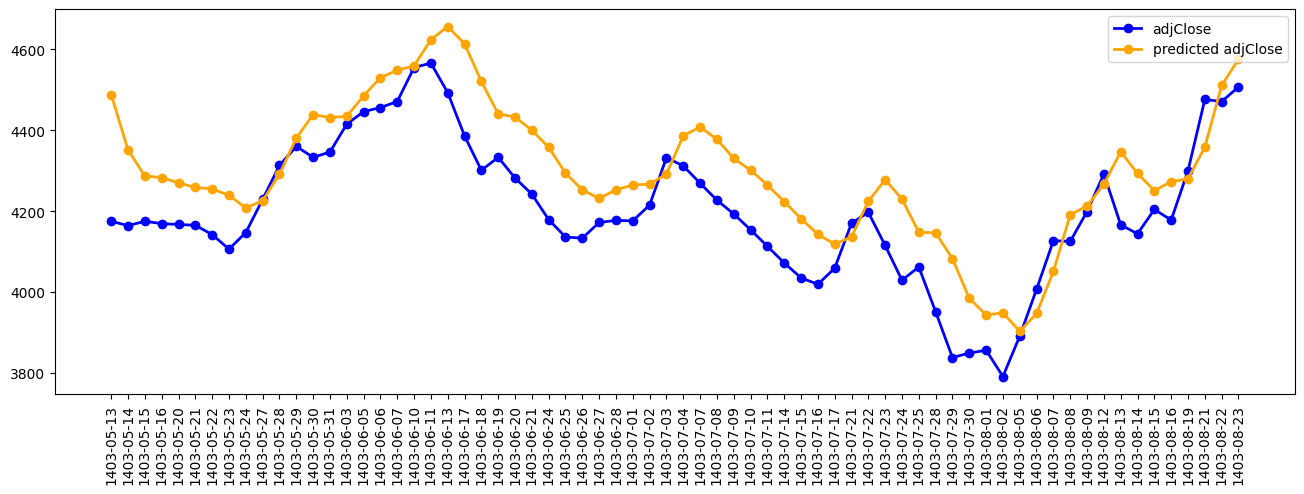

In [31]:
y_pred=(model2.predict(X_test)).reshape(-1)
plt.figure(figsize=(16, 5))
plt.plot(list(data['Date'][-len(y_test):]), y_test, color='blue', marker='o', linewidth=2, label='adjClose')
plt.plot(list(data['Date'][-len(y_pred):]), y_pred, color='orange', marker='o', linewidth=2, label='predicted adjClose')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

<div style="text-align: justify; direction: rtl; font-family: 'B Nazanin'; font-size: 15px;">
همانطور که قابل مشاهده است، مدل دارای تحلیل احساسات به صورت قابل توجهی بهتر از مدل بدون تحلیل حساسایت عمل کرده است.

In [26]:
pd.DataFrame([[mae2,mae],[loss2,loss]],index=['MAE','MSE'],columns=['Model without sentiments','Model with sentiments'])

,Model without sentiments,Model with sentiments
MAE,104.702736,62.949249
MSE,15111.284180,6169.844727
